Analysis of the error of regression models depending on the corrugation

In [1]:
# -*- coding: utf-8 -*-
'Evaluate models and create JSON of metrics'

# -*- coding: utf-8 -*-
# IMPORTS
# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import json
import sys
import pickle
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')

# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)



# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, train_for_epoch, save_config, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_regression

from utils.models import resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, regressor_from_checkpoint, \
                            AtomCountPredictor


from utils.dataloader import  QUAM_atom_regressor_10_imgs, dataset_ks_dict, parse_k1_to_k, parse_val_ks

from utils.evaluation import virtual_epoch_paths

print('Packages loaded')

# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.device(0)
print(device, torch.cuda.get_device_name(0))


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'debug_regression'
        self.n_fp = 1024  # number of fingerprints of the backbone model
        self.output_size = 10 # output size of regressor model
        self.ratio = 0.95  # train/test ratio
        self.seed = 42
        self.virtual_epochs = 10 # number of times we save the model per epoch. If equal to 1
                                # we only save at the end of each epoch.
        self.tqdm_flag = True

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 100  # Test batch size
        self.epochs = 100  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.7  # prob of applying zoom
        self.max_zoom = 0.7  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

        # Gaussian noise
        self.gauss_noise = 2 # std of gaussian noise

        # comments
        self.comments = 'It uses all K folders'

        # METRICS AND MODELS PATHS
        self.exp_path = os.path.join('./experiments', self.experiment_name)
        self.metrics_path = os.path.join(self.exp_path, 'metrics')
        self.models_path = os.path.join(self.exp_path, 'models')



## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)
# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Load data

data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_w_H_df.gz'
dataset_df = pd.read_pickle(data_path)

test_df = dataset_df[dataset_df['split'] == 'test']
test_k_df = parse_val_ks(test_df)


testset = QUAM_atom_regressor_10_imgs(args, test_k_df, mode='test')
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=7,
                                           pin_memory=True)

print('Test set samples:', len(testset))





# model and metrics initialization
criterion = nn.MSELoss()

models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/regression_w_H/models'
checkpoint_path = os.path.join(models_path, 'checkpoint_2_virtual_epoch_1.pth')

pretrained_model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)
model = AtomCountPredictor(pretrained_model, output_size=args.output_size).to(device)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])


print('Finished')


PyTorch version: 1.12.1
PyTorch version: 1.12.1
Packages loaded
available devices: 1
cuda:0 NVIDIA A40
Experiment name: debug_regression


/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set samples: 279848
Finished


In [2]:
print(5)

5


In [3]:
dict_path = f'/home/{USER}/QUAM-AFM/DICTIONARIES/cid_corrugation_dict.pickle'
with open(dict_path, 'rb') as handle:
    cid_corrugation_dict = pickle.load(handle)

In [4]:
test_k_df['corrugation'] = [cid_corrugation_dict[str(x)] for x in test_k_df['CID']]

In [ ]:
model.eval()

test_predictions = []
ground_truth = []

with torch.no_grad():
    for batch, target in tqdm(test_loader):

        # move data to the device
        batch = batch.to(device)

        # make predictions
        predictions = torch.round(model(batch))
        ground_truth.append(target.cpu().detach().numpy())
        test_predictions.append(predictions.cpu().detach().numpy())

test_predictions = np.concatenate(test_predictions)
ground_truth = np.concatenate(ground_truth)

 57%|██████████████████████▎                | 1605/2799 [15:29<04:56,  4.03it/s]

In [9]:
print(test_predictions.shape, ground_truth.shape)

(166300, 10) (166300, 10)


In [16]:
INDEX = 35
print(test_k_df.iloc[INDEX])
print(ground_truth[INDEX])
print(test_predictions[INDEX])


CID                                                     12368358
C                                                              5
Br                                                             0
Cl                                                             0
F                                                              0
I                                                              0
N                                                              1
O                                                              1
P                                                              0
S                                                              1
H                                                              7
split                                                       test
path           /scratch/dataset/quam/K-1/Conformer3D_CID_1236...
corrugation                                               0.0005
Name: 77, dtype: object
[5. 0. 0. 0. 0. 1. 1. 0. 1. 7.]
[5. 0. 0. 0. 0. 1. 1. 0. 1. 7.]


### Compute classification accuracy and regression metrics


In [17]:
print(test_k_df.iloc[:10])
print(ground_truth[:10])
print(test_predictions[:10])

          CID   C  Br  Cl  F  I  N  O  P  S   H split  \
1    10001048  25   0   0  0  0  6  0  0  0  16  test   
7       10005   2   0   0  0  0  4  0  0  0   4  test   
14  100128716  15   0   0  0  0  3  0  0  0  21  test   
15  100175925  10   0   0  0  0  3  4  0  2   9  test   
16  100197007  18   0   0  0  0  3  4  0  2  13  test   
18  100197976  20   0   0  0  0  2  3  0  1  14  test   
23     228827   7   0   0  0  0  6  2  0  0   8  test   
24     228834  14   0   0  0  0  8  4  0  0   8  test   
25   22886611  11   0   0  0  0  0  1  0  1  12  test   
27   22886614  14   0   0  0  0  0  0  0  1  12  test   

                                                 path  corrugation  
1   /scratch/dataset/quam/K-1/Conformer3D_CID_1000...       1.1767  
7   /scratch/dataset/quam/K-1/Conformer3D_CID_1000...       0.0002  
14  /scratch/dataset/quam/K-1/Conformer3D_CID_1001...       0.0110  
15  /scratch/dataset/quam/K-1/Conformer3D_CID_1001...       0.0530  
16  /scratch/dataset/quam/K

In [26]:
(test_k_df[['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H']]<1).sum()/len(test_k_df)

C     0.000036
Br    0.823697
Cl    0.758072
F     0.817633
I     0.959900
N     0.079147
O     0.215213
P     0.998867
S     0.752977
H     0.000386
dtype: float64

In [ ]:
(ground_truth<1).sum(axis=0)/len(ground_truth)

#### Compute classification metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
atom_list = ['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H']
gt_class = (ground_truth>0)
pred_class = (test_predictions>0)
class_atom_dict = dict()
for i, atom in enumerate(atom_list):
    prec, recall, f1_score, _ = precision_recall_fscore_support(gt_class[:, i], pred_class[:, i], average='binary')
    class_atom_dict[atom] = {'precision': prec, 
                             'recall': recall, 
                             'f1_score': f1_score}

    

In [ ]:
class_atom_dict

In [ ]:

def create_latex_table(class_atom_dict):
    headers = ['Atom', 'Precision', 'Recall', 'F1 Score']
    rows = []

    for atom, scores in class_atom_dict.items():
        precision = "{:.4f}".format(scores['precision'])
        recall = "{:.4f}".format(scores['recall'])
        f1_score = "{:.4f}".format(scores['f1_score'])
        row = f"{atom} & {precision} & {recall} & {f1_score} \\\\"
        rows.append(row)

    latex_table = "\\begin{table}[h]\n\\centering\n\\caption{Atom Classification Scores}\n\\begin{tabular}{cccc}\n"
    latex_table += " & ".join(headers) + " \\\\\n"
    latex_table += "\\hline\n"
    latex_table += "\n".join(rows)
    latex_table += "\n\\end{tabular}\n\\end{table}"

    return latex_table
table = create_latex_table(class_atom_dict)
print(table)

#### Compute mse and pearson correlation for each atom

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import r_regression
atom_list = ['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H']
reg_metrics_atom = dict()
for i, atom in enumerate(atom_list):
    mse = mean_squared_error(ground_truth[:, i], test_predictions[:, i])
    pearson_r = r_regression(ground_truth[:, i].reshape(-1, 1), test_predictions[:, i].reshape(-1, 1))
    reg_metrics_atom[atom] = {'mse': mse, 
                              ''' Pearson's r''': pearson_r[0]}

    

In [ ]:
reg_metrics_atom

In [ ]:
def create_publication_table_latex(data_dict):
    headers = ['Atom', 'MSE', "Pearson's r"]
    rows = []

    for atom, values in data_dict.items():
        mse = "{:.8f}".format(values['mse'])
        pearson_r = "{:.4f}".format(values[" Pearson's r"])
        row = f"{atom} & {mse} & {pearson_r} \\\\"
        rows.append(row)

    latex_table = "\\begin{table}[h]\n\\centering\n\\caption{Atom Regression Scores}\n\\begin{tabular}{ccc}\n"
    latex_table += " & ".join(headers) + " \\\\\n"
    latex_table += "\\hline\n"
    latex_table += "\n".join(rows)
    latex_table += "\n\\end{tabular}\n\\end{table}"

    return latex_table
table = create_publication_table_latex(reg_metrics_atom)
print(table)

(166300, 1)

In [ ]:
reg_metrics_atom

In [14]:
valid_loss, valid_accuracy, acc_atom_dict = validate_regression(model, test_loader, criterion, device)

print('valid_loss:', valid_loss)
print('valid_accuracy:', valid_accuracy)
print('acc_atom_dict:', acc_atom_dict)


valid_loss: 0.027798590250313282
valid_accuracy: 0.74
acc_atom_dict: {'C': 0.77, 'Br': 1.0, 'Cl': 1.0, 'F': 1.0, 'I': 1.0, 'N': 0.97999996, 'O': 0.97999996, 'P': 1.0, 'S': 0.99}


### Accuracy vs corrugation


In [3]:
test_df = dataset_df[dataset_df['split'] == 'test']
test_k_df = parse_val_ks(test_df)
test_k_df['corrugation'] = [cid_corrugation_dict[str(x)] for x in test_k_df['CID']]

In [7]:
test_df['corrugation'] = [cid_corrugation_dict[str(x)] for x in test_df['CID']]

/tmp/ipykernel_89480/4062025341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['corrugation'] = [cid_corrugation_dict[str(x)] for x in test_df['CID']]


In [73]:
test_high_corr = parse_val_ks(test_df[test_df['corrugation']>=1.25])
testset = QUAM_atom_regressor_10_imgs(args, test_high_corr, mode='test')
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=7,
                                           pin_memory=True)

valid_loss, valid_accuracy, acc_atom_dict = validate_regression(model, test_loader, criterion, device)

print('valid_loss:', valid_loss)
print('valid_accuracy:', valid_accuracy)
print('acc_atom_dict:', acc_atom_dict)

valid_loss: 0.08787984072322935
valid_accuracy: 0.65961313
acc_atom_dict: {'C': 0.77149034, 'Br': 0.92937464, 'Cl': 0.93608713, 'F': 0.97761124, 'I': 0.97533625, 'N': 0.92047817, 'O': 0.9364514, 'P': 0.99686, 'S': 0.97303796}


In [74]:
test_low_corr = parse_val_ks(test_df[test_df['corrugation']<0.25].iloc[:15000])

testset = QUAM_atom_regressor_10_imgs(args, test_low_corr, mode='test')
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=7,
                                           pin_memory=True)

valid_loss, valid_accuracy, acc_atom_dict = validate_regression(model, test_loader, criterion, device)

print('valid_loss:', valid_loss)
print('valid_accuracy:', valid_accuracy)
print('acc_atom_dict:', acc_atom_dict)

valid_loss: 0.029071598338584106
valid_accuracy: 0.8096
acc_atom_dict: {'C': 0.8254667, 'Br': 0.9996, 'Cl': 0.9988667, 'F': 1.0, 'I': 0.99986666, 'N': 0.97386706, 'O': 0.98786736, 'P': 0.99986666, 'S': 0.99513346}


In [37]:
# for all data
test_k_df = parse_val_ks(test_df)
testset = QUAM_atom_regressor_10_imgs(args, test_k_df, mode='test')
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=7,
                                           pin_memory=True)

test_predictions = []
ground_truth = []

with torch.no_grad():
    for batch, target in tqdm(test_loader):

        # move data to the device
        batch = batch.to(device)

        # make predictions
        predictions = torch.round(model(batch))
        ground_truth.append(target.cpu().detach().numpy())
        test_predictions.append(predictions.cpu().detach().numpy())

test_predictions = np.concatenate(test_predictions)
ground_truth = np.concatenate(ground_truth)

 68%|██████████████████████████            | 1917/2800 [16:35<07:38,  1.93it/s]


RuntimeError: DataLoader worker (pid 89862) is killed by signal: Killed. 

In [38]:
test_predictions = np.concatenate(test_predictions)
ground_truth = np.concatenate(ground_truth)

In [39]:
len(ground_truth)

191700

In [40]:
C_diff = np.abs(test_predictions[:, 0] - ground_truth[:, 0])
corr = np.asarray(list(test_k_df['corrugation'].iloc[:191700]))

In [41]:
carbon_diff_df = pd.DataFrame({'C_diff': C_diff, 'corrugation':corr})


In [ ]:
carbon_diff_df.to_pickle('carbon_diff_df.gzip')

Text(0.5, 0, 'Error in C prediction')

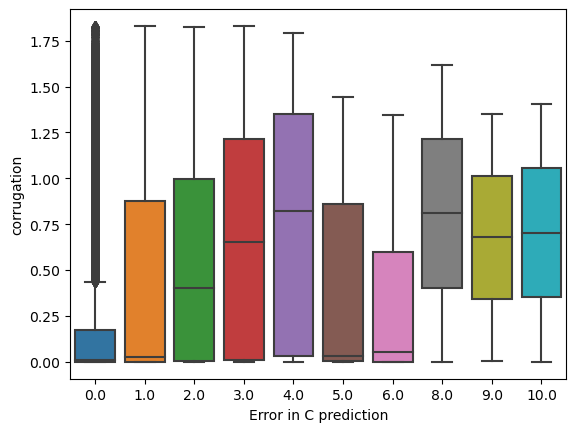

In [42]:
import seaborn as sns
sns.boxplot(data=carbon_diff_df, x='C_diff', y='corrugation')
plt.xlabel('Error in C prediction')


In [ ]:
import seaborn as sns
sns.boxplot(data=carbon_diff_df, x='C_diff', y='corrugation')
plt.xlabel('Error in C prediction')


### Data Analysis of atom counts

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

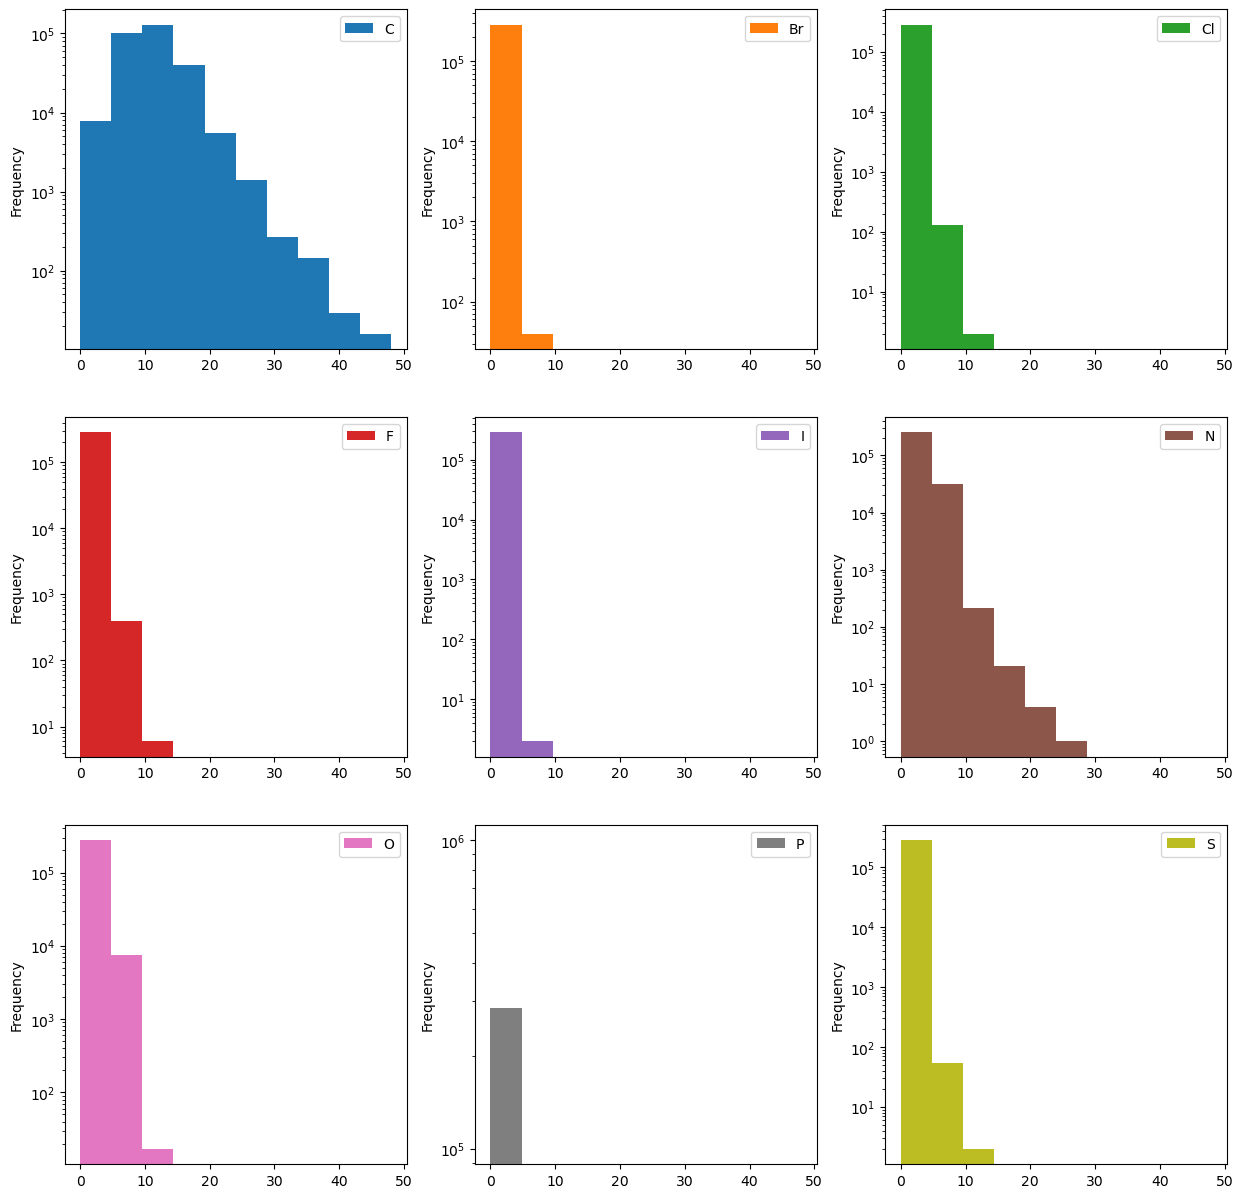

In [5]:
train_df = dataset_df[dataset_df['split'] == 'train']
train_df[['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']].plot.hist(subplots=True, legend=True, layout=(3, 3),
                                                                   figsize = [15, 15], logy=True, sharex=False)

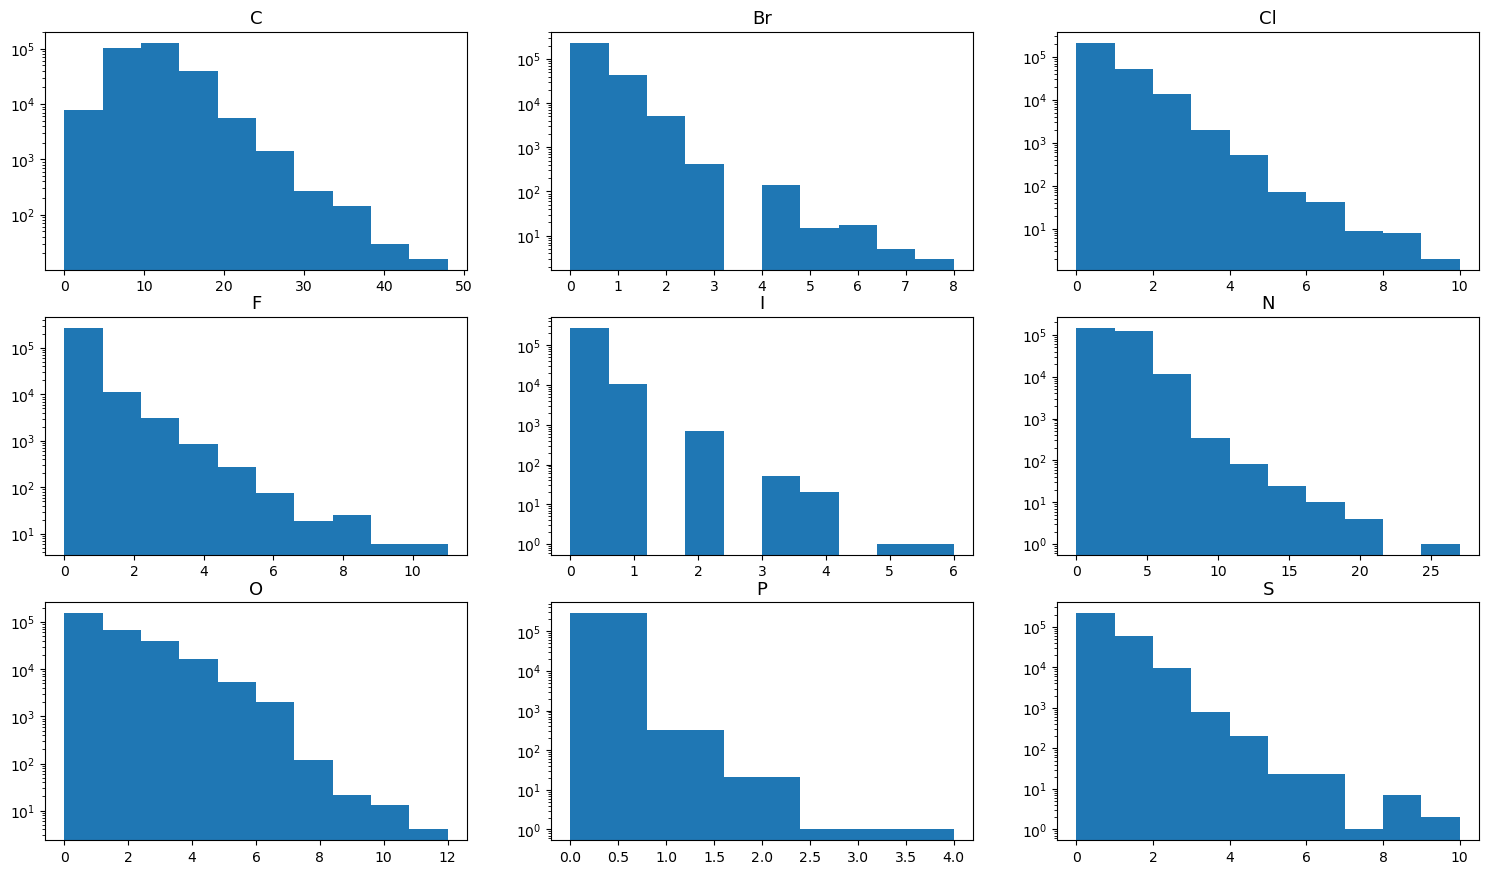

In [6]:
fig, ax = plt.subplots(3,3)

for i, col in enumerate(['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']):
    if (col == 'P'):
        ax[i//3, i%3].hist(train_df[col], density=False, log=True, bins=5)
        ax[i//3, i%3].set_title(col, fontsize = 13)
    else:
        ax[i//3, i%3].hist(train_df[col], density=False, log=True)
        ax[i//3, i%3].set_title(col, fontsize = 13)
    
fig.set_size_inches(18.5, 10.5)
plt.show()

### Compute accuracy on hallogens when there is at least 1
Since there are far more cases of molecules with 0 hallogens than 1, we compute the accuracy over molecules that at least have 1 hallogen.

In [13]:
for atom in ['Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']:   
    print(f'Obtaining statistics for atom {atom}')
    subset_df = test_df[test_df[atom]>=1]


    testset = QUAM_atom_regressor_10_imgs(args, parse_val_ks(subset_df), mode='test')
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=True, num_workers=7,
                                           pin_memory=True)
    valid_loss, valid_accuracy, acc_atom_dict = validate_regression(model, test_loader, criterion, device)
    print('valid_loss:', valid_loss)
    print('valid_accuracy:', valid_accuracy)
    print('acc_atom_dict:', acc_atom_dict)
    
    print('---------------------------------')


Obtaining statistics for atom Br
valid_loss: 0.022235761840567594
valid_accuracy: 0.9005263
acc_atom_dict: {'C': 0.9338688, 'Br': 0.97172004, 'Cl': 0.9933593, 'F': 0.99724627, 'I': 0.9775904, 'N': 0.9866381, 'O': 0.99186105, 'P': 1.0, 'S': 0.9987446}
---------------------------------
Obtaining statistics for atom Cl
valid_loss: 0.02900625335815538
valid_accuracy: 0.87083036
acc_atom_dict: {'C': 0.9117307, 'Br': 0.96507305, 'Cl': 0.96207756, 'F': 0.99630827, 'I': 0.99583584, 'N': 0.98178226, 'O': 0.9891331, 'P': 0.99997044, 'S': 0.9969874}
---------------------------------
Obtaining statistics for atom F
valid_loss: 0.03159407262547155
valid_accuracy: 0.8563086
acc_atom_dict: {'C': 0.8946086, 'Br': 0.98460245, 'Cl': 0.9870505, 'F': 0.97731614, 'I': 0.9957481, 'N': 0.9780776, 'O': 0.97208637, 'P': 0.9999412, 'S': 0.9970806}
---------------------------------
Obtaining statistics for atom I
valid_loss: 0.01741292145103216
valid_accuracy: 0.92897767
acc_atom_dict: {'C': 0.9491559, 'Br': 0.9

In [16]:
data_path = '/home/manuel/QUAM-AFM/datasets/atoms_count_df.gz'
dataset_df = pd.read_pickle(data_path)

test_df = dataset_df[dataset_df['split'] == 'test']
subset_df = test_df[test_df['P']>=1]

In [19]:
for atom in ['Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']:   

    subset_df = test_df[test_df[atom]>=1]
    print(f'{len(subset_df)}')

49354
67724
51045
11232
257743
219665
317
69131


### Check frequency of atom appereance
We want to know in how many molecules a certain atom appears

In [3]:
data_path = f'/home/{USER}/QUAM-AFM/datasets/atoms_count_w_H_df.gz'
dataset_df = pd.read_pickle(data_path)
train_df = dataset_df[dataset_df['split'] == 'train']

In [9]:
(train_df[['C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H']]>1).mean(axis=0)*100

C     99.937180
Br     1.994806
Cl     5.682249
F      5.414473
I      0.277251
N     75.263915
O     46.300625
P      0.008072
S      3.688847
H     99.663789
dtype: float64